In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, subprocess
import seaborn as sns
import matplotlib.pyplot as plt
print(os.listdir("./data-readonly"))

['test.csv.gz', 'sample_submission.csv.gz', 'shops.csv', 'sales_train.csv.gz', 'item_categories.csv', 'items.csv']


In [3]:
%matplotlib inline

## Load Training Data

In [4]:
fpath = "./data-readonly/sales_train.csv.gz"
dtype = {"date_block_num": "int8",
         "item_id": "uint16",
         "shop_id": "int8",
         "item_price": "float64",
         "item_cnt_day": "int16"}
df_Train = pd.read_csv(fpath, compression="gzip", parse_dates=["date"], dtype=dtype,
                       date_parser=lambda x: pd.to_datetime(x, format="%d.%m.%Y"))

In [5]:
df_Train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1
1,2013-01-03,0,25,2552,899.00,1
2,2013-01-05,0,25,2552,899.00,-1
3,2013-01-06,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


## Basic Statics of Training Data

In [6]:
df_Train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


## The trend of number of records
---
It looks like the transactions double around new year.

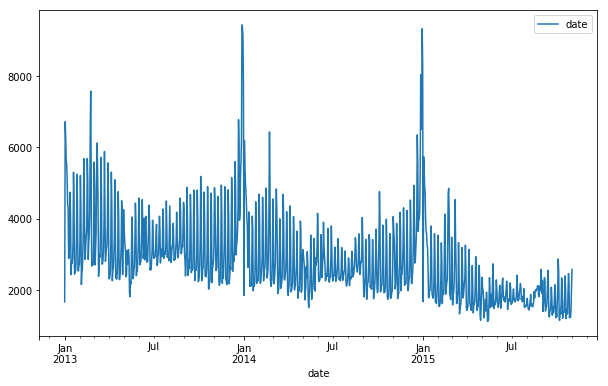

In [7]:
df_Train.groupby("date").agg({"date": "count"}).plot(figsize=(10, 6));

We can clearly see two peaks happened at 2014/01 and 2015/01.

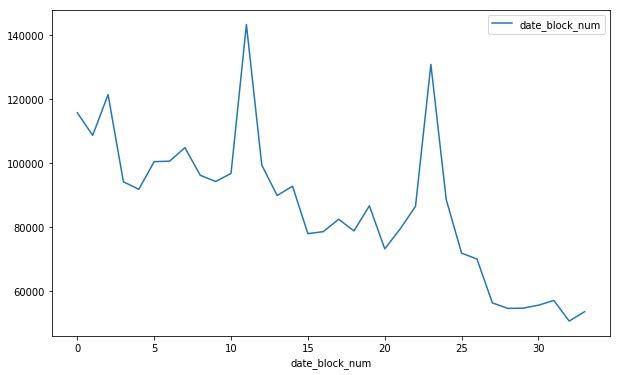

In [8]:
df_Train.groupby("date_block_num").agg({"date_block_num": "count"}).plot(figsize=(10, 6));

* We can see that the transactions go up very quickly from Dec. to Jan.
* November surprisingly has lowest number of transactions.

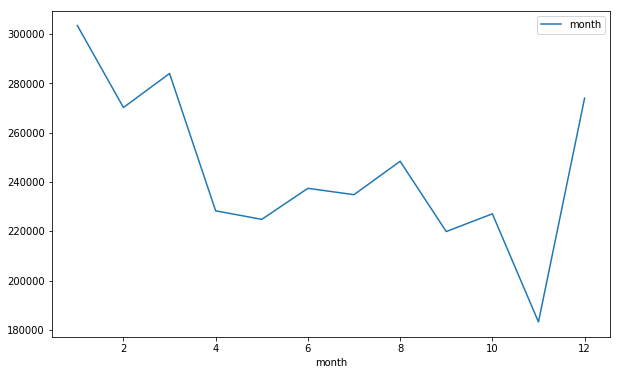

In [9]:
df_Train["month"] = df_Train["date"].dt.month
df_Train.groupby("month").agg({"month": "count"}).plot(figsize=(10, 6));

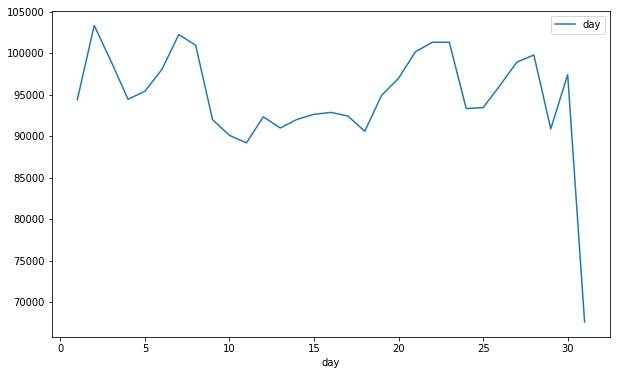

In [10]:
df_Train["day"] = df_Train["date"].dt.day
df_Train.groupby("day").agg({"day": "count"}).plot(figsize=(10, 6));

## Does every item exist in all shops for training data
---
No, for the 21807 unique items, there's no single item exits in all 60 shops

In [11]:
df_Train["shop_id"].nunique(), df_Train["item_id"].nunique()

(60, 21807)

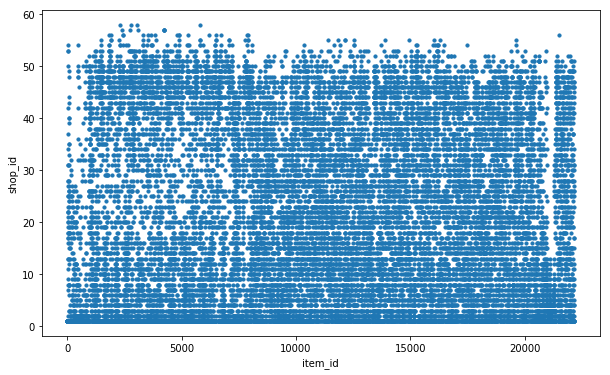

In [12]:
df_Train.groupby("item_id").agg({"shop_id": "nunique"}).reset_index().plot.scatter("item_id", "shop_id", figsize=(10, 6), s=10);

## Load Testing Data

In [7]:
fpath = "./data-readonly/test.csv.gz"
dtype = {"item_id": "uint16",
         "shop_id": "int8",}
df_Test = pd.read_csv(fpath, dtype=dtype, index_col="ID")

## Does every item exist in all shops for testing data
---
Yes, for the 5100 unique items, each item has been sold in all 42 shops

In [8]:
set(df_Test["shop_id"])-set(df_Train["shop_id"])

NameError: name 'df_Train' is not defined

In [9]:
df_Test["shop_id"].nunique(), df_Test["item_id"].max()

(42, 22167)

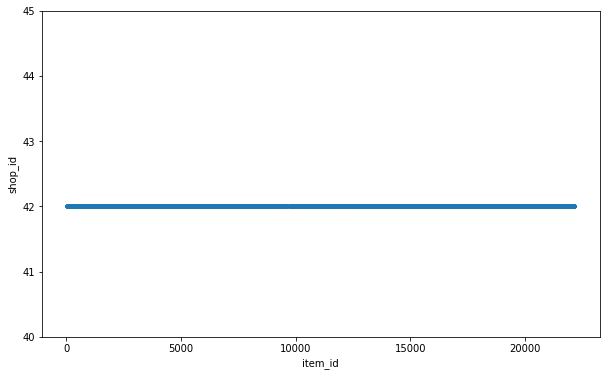

In [16]:
df_Test.groupby("item_id").agg({"shop_id": "nunique"}).reset_index().plot.scatter("item_id", "shop_id", figsize=(10, 6), s=10)
plt.ylim(40, 45);

## Does every shop in testing data have history record for every item.
---
Wow, we can see that some shops do have historical data almost across all items.

In [17]:
cols = ["shop_id", "item_id"]
df_ShopItem = df_Train.groupby(cols).agg({"item_id": "nunique"}).rename(columns={"item_id": "Exist"}).reset_index()
df_ShopItem = df_Test.merge(df_ShopItem, on=cols, how="left").fillna(0)

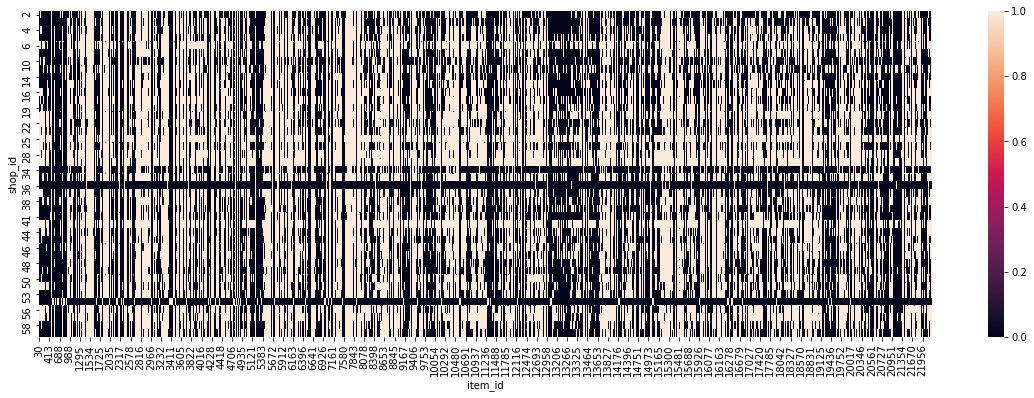

In [18]:
_, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.heatmap(df_ShopItem.pivot("shop_id", "item_id", "Exist"), ax=ax);

In [19]:
df_ShopItem.groupby(["shop_id"]).agg({"Exist": "sum"}).sort_values("Exist")

,Exist
shop_id,
36,252.0
55,399.0
34,1261.0
2,1913.0
3,2119.0
10,2120.0
49,2133.0
39,2253.0
41,2349.0


## Does every item in testing data exist in training data
---
No. There are only 4737 items exist in training data but there are 363 items missing. Also, some items are rarely selling in shops.

In [20]:
items_testing = set(df_Test["item_id"])
items_training = set(df_Train["item_id"])
len(items_testing - items_training)

363

## Read items data

In [3]:
fpath = "./data-readonly/items.csv"
df_Items = pd.read_csv(fpath)
df_Items.item_id.unique()

array([    0,     1,     2, ..., 22167, 22168, 22169])

In [24]:
df_Items.groupby('item_category_id').count().sort_values(by=['item_name'], ascending=False)

,item_name,item_id
item_category_id,,
40,5035,5035
55,2365,2365
37,1780,1780
31,1125,1125
58,790,790
30,756,756
72,666,666
19,628,628
61,598,598


40 = DVD
55 = CD
37 = BD
31 = Collection ?
58 = LP (music)
30 = PC-CD
72 = Games
19 = PS3 Games
61 = Games ?
23 = Xbox 360
43 = mp3-CD
57 = (mp3-CD) (Digipack)
56 = music pack ?
67 = 3D Action Puzzle
63 = ?
76 = Software
41 = DVD-Packs
69 = USB drive
38 = BD-Packs
62 = Astrojax etc.
59 = Music DVD

In [71]:
df_Items.loc[3].item_name

'***ГОЛУБАЯ ВОЛНА  (Univ)                      D'